[View in Colaboratory](https://colab.research.google.com/github/Naritoshi/colabo_deeplearning_practice/blob/master/cnn_kaggle_data_classifier.ipynb)

#kaggleからデータ取得し、画像分類する（未完成）

##Kaggleからデータを取得する

###KaggleAPIのインストール

In [1]:
!pip install kaggle

    100% |████████████████████████████████| 51kB 4.1MB/s 
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /content/.cache/pip/wheels/5e/45/f9/87cd2b0ac15f910d09ba5005be2cf33013177573bda7d57cb7
Successfully built kaggle


###kaggle の認証設定

認証の取得は、 [ここ](https://qiita.com/h_kobayashi1125/items/749f63577a7353771969)を参考にしました。

「kaggle.json」を ```「https://www.kaggle.com/アカウント名/account」```より取得します。

取得したファイルをGoogleDriveにアップロードすます。

取得したファイルを「~/.kaggle/kaggle.json」に配置します。

In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


アップロードされた確認します。

In [4]:
import os
os.listdir('/content/.kaggle/')

['kaggle.json']

### DataSetのダウンロード

KaggelAPIを使って、ファイルをダウンロードする

In [5]:
!kaggle datasets download -d moltean/fruits

 99%|████████████████████████████████████████▌| 196M/198M [00:01<00:00, 103MB/s]
100%|█████████████████████████████████████████| 198M/198M [00:01<00:00, 152MB/s]


ダウンロードできたか確認します。

In [6]:
os.listdir('/content/.kaggle/datasets/moltean/fruits')

['fruits.zip', 'fruits-360_dataset_2018_06_03.zip']

ダウンロードしたファイルを解凍します。

In [0]:
import zipfile
with zipfile.ZipFile('/content/.kaggle/datasets/moltean/fruits/fruits-360_dataset_2018_06_03.zip') as existing_zip:
    existing_zip.extractall()

解凍できたか確認します。
フォルダ名「fruits-360」が出来ているはずです。

In [8]:
os.listdir()

['datalab',
 '.cache',
 '.ipython',
 '.forever',
 '.config',
 '.local',
 'fruits-360',
 '.kaggle',
 '.rnd']

画像のパスを確認する

フォルダの確認をします。
以下の感じで、データが入っているようです。

学習データ：fruits-360/Traning/

検証データ：fruits-360/Validation/

In [9]:
import glob

_ = [print(x) for x in glob.glob("fruits-360/*/", recursive=True)]

fruits-360/papers/
fruits-360/test-multiple_fruits/
fruits-360/Validation/
fruits-360/Training/


学習データのフォルダを見てみます

In [10]:
_ = [print(x) for x in glob.glob("fruits-360/**/*.jpg", recursive=True)[:10]]

fruits-360/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum_2.jpg
fruits-360/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum_3.jpg
fruits-360/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum.jpg
fruits-360/test-multiple_fruits/apple_apricot_nectarine_peach_peach(flat)_pomegranate_pear_plum.jpg
fruits-360/Validation/Dates/r_82_100.jpg
fruits-360/Validation/Dates/7_100.jpg
fruits-360/Validation/Dates/124_100.jpg
fruits-360/Validation/Dates/132_100.jpg
fruits-360/Validation/Dates/r_316_100.jpg
fruits-360/Validation/Dates/r_99_100.jpg


###データの確認

画像を1つ表示する

(100, 100)


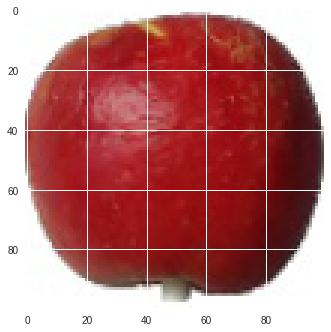

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('fruits-360/Training/Apple Red Yellow/273_100.jpg')

#サイズは、100x100のようです
print(img.size)
plt.imshow(img)
plt.show()

複数の画像を表示する

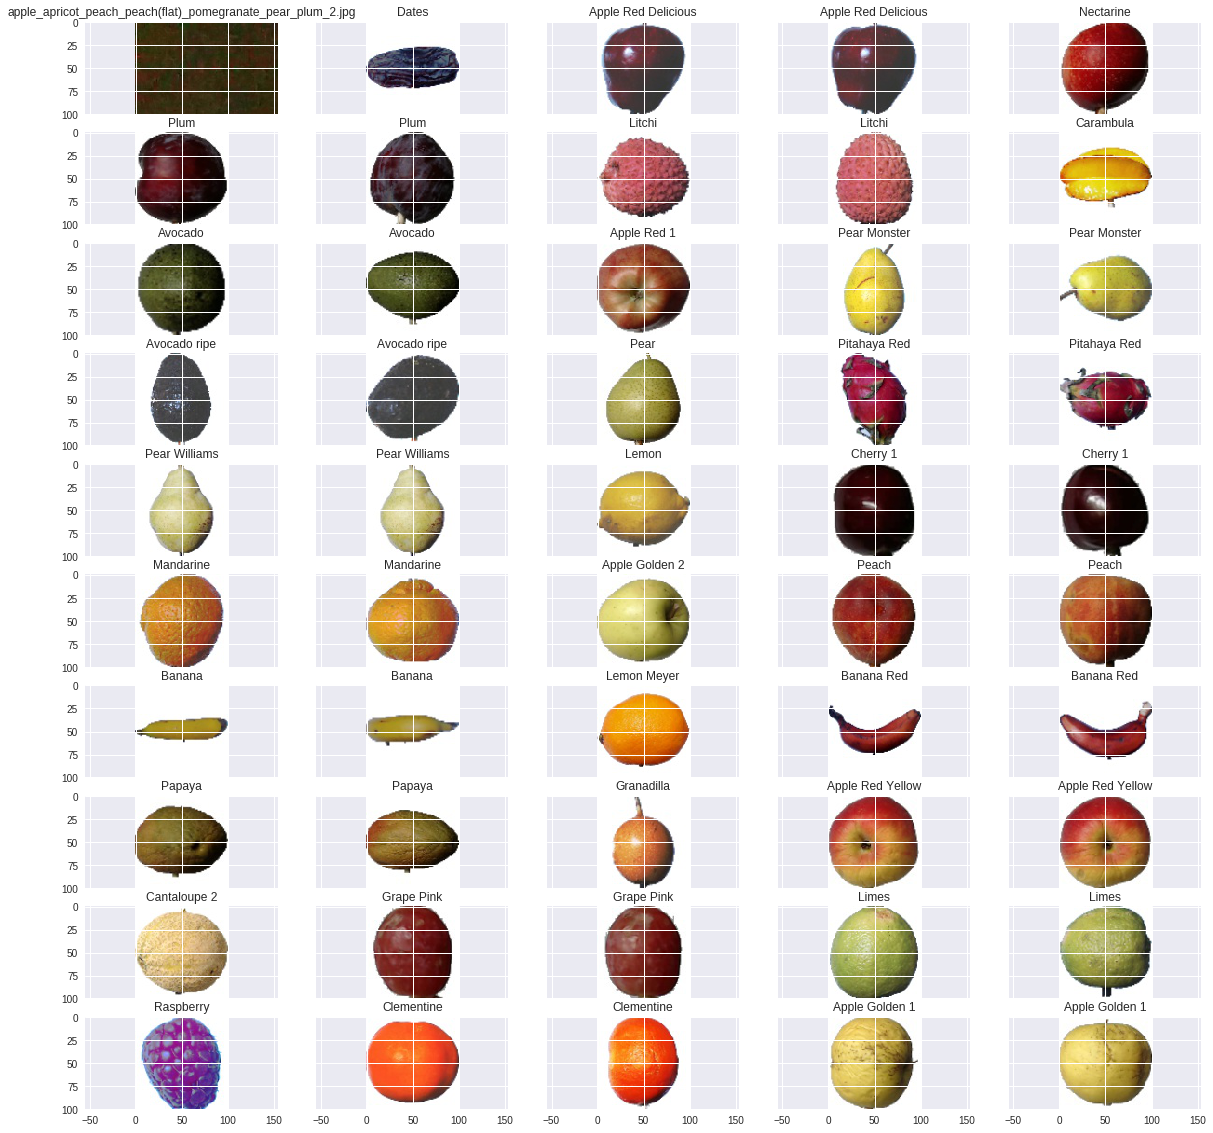

In [12]:
#画像のパスをすべて取得する
img_path_list = glob.glob("fruits-360/**/*.jpg", recursive=True)

#figsizeで大きさを指定できます
fig,ax = plt.subplots(nrows=10,ncols=5, sharex=True, sharey=True,figsize=(20, 20))

#一次元で扱えるようにする
ax = ax.flatten()

for i in range(50):
  #100掛けて、適当に表示
  img_path = img_path_list[i * 100]
  img = Image.open(img_path)
  #ファイル名を表示する
  name = img_path.split('/')[2]
  ax[i].set_title(name)
  ax[i].imshow(img)
  

##Chainerをインストールします

chainerをインストールします。
GPUを使うので、cupy-cuda80もインストールします。

In [13]:
!pip uninstall chainer -y
!pip uninstall cupy-cuda80 -y
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install 'chainer==4.0.0b4' 'cupy-cuda80==4.0.0b4'
!pip install chainer -U
!pip install cupy-cuda80 -U

Skipping chainer as it is not installed.
Skipping cupy-cuda80 as it is not installed.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 2s (14.3 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [.

    100% |████████████████████████████████| 205.4MB 104kB/s 
    100% |████████████████████████████████| 81kB 19.9MB/s 
  Running setup.py bdist_wheel for chainer ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/89/2e/12/fe6441d846a967c24ded700e140bc2a71f56044199b72f33dc
  Running setup.py bdist_wheel for filelock ... - done
  Stored in directory: /content/.cache/pip/wheels/35/ba/67/4cc48738870c3b54f9e3b5d78bf9de130befb70c1d359faf8b
Successfully built chainer filelock
    100% |████████████████████████████████| 399kB 5.4MB/s 
Requirement not upgraded as not directly required: filelock in /usr/local/lib/python3.6/dist-packages (from chainer) (3.0.4)
Requirement not upgraded as not directly required: numpy>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from chainer) (1.14.3)
Requirement not upgraded as not directly required: protobuf>=3.0.0 in /usr/local/lib/python3.6/dist-packages (from chainer) (3.5.2.post1)
Requirement not upgraded as not directly re

    100% |████████████████████████████████| 194.0MB 115kB/s 
Requirement not upgraded as not directly required: setuptools in /usr/local/lib/python3.6/dist-packages (from protobuf>=3.0.0->chainer) (39.2.0)
Requirement not upgraded as not directly required: fastrlock>=0.3 in /usr/local/lib/python3.6/dist-packages (from cupy-cuda80==4.1.0->chainer) (0.3)
  Running setup.py bdist_wheel for chainer ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/f7/bc/ce/ded86aa42c54308c8bc62410164af1c614cdecc0df3a204af4
Successfully built chainer
  Found existing installation: cupy-cuda80 4.0.0b4
    Uninstalling cupy-cuda80-4.0.0b4:
      Successfully uninstalled cupy-cuda80-4.0.0b4
  Found existing installation: chainer 4.0.0b4
    Uninstalling chainer-4.0.0b4:
      Successfully uninstalled chainer-4.0.0b4
Requirement already up-to-date: cupy-cuda80 in /usr/local/lib/python3.6/dist-packages (4.1.0)
Requirement not upgraded as not directly required: fastrlock>=0.3 in /

GPUが有効になっていることを確認する

In [14]:
import chainer
import cupy
chainer.print_runtime_info()
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

Chainer: 4.1.0
NumPy: 1.14.3
CuPy:
  CuPy Version          : 4.1.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2104
GPU availability: True
cuDNN availablility: True


##Chainer用のデータセットを作る

[LabeledImageDataset](https://github.com/chainer/chainer/blob/v4.1.0/chainer/datasets/image_dataset.py)を利用して、データセットを作ります。


「画像のパス、正解ラベル(int型)をタプル」の配列または、
「画像パス,正解ラベル 」のファイルとする必要があります。

「画像パス,正解ラベル 」のファイルの場合、
ディレクトリ名に空白があるとダメっぽいので、
「画像のパス、正解ラベル(int型)をタプル」の配列でやります。

正解ラベルの配列を作る

In [1]:
import os
#これで重複なく、ラベルとなるディレクトリが取れます。
IMG_LABLEL_PATH = './fruits-360/Training/'
label_path_list = [x for x in os.listdir(IMG_LABLEL_PATH) if os.path.isdir(os.path.join(IMG_LABLEL_PATH, x))]

#ラベルの件数を確認します
print(len(label_path_list))

#10件表示してみます
_  = [print(x) for x in label_path_list[:10]]

65
Dates
Apple Red Delicious
Nectarine
Plum
Litchi
Carambula
Avocado
Apple Red 1
Pear Monster
Avocado ripe


「画像のパス、正解ラベル(int型)をタプル」の配列でデータセットを作ります。

In [2]:
def get_path_and_label_index(img_path):
  #ディレクトリ名を取得します。
  full_directri_name = os.path.dirname(img_path)
  directri_name = os.path.basename(full_directri_name)
  label_index = label_path_list.index(directri_name)
  return (img_path, label_index)

get_path_and_label_index('fruits-360/Training/Apple Red Yellow/273_100.jpg')

('fruits-360/Training/Apple Red Yellow/273_100.jpg', 23)

In [3]:
import glob
#学習、検証の画像パスから、画像パス、ラベルの配列を作ります
train_img_path_and_label_list = [get_path_and_label_index(x) for x in glob.glob('fruits-360/Training/**/*.jpg')]
varid_img_path_and_label_list = [get_path_and_label_index(x) for x in  glob.glob('fruits-360/Validation/**/*.jpg')]

#サイズを確認します。
print(len(train_img_path_and_label_list))
print(len(varid_img_path_and_label_list))

#３件表示してみます
print(train_img_path_and_label_list[3])
print(train_img_path_and_label_list[1000])
print(varid_img_path_and_label_list[10000])

32426
10903
('fruits-360/Training/Dates/r_300_100.jpg', 0)
('fruits-360/Training/Nectarine/261_100.jpg', 2)
('fruits-360/Validation/Cactus fruit/274_100.jpg', 59)


[LabeledImageDataset](https://github.com/chainer/chainer/blob/v4.1.0/chainer/datasets/image_dataset.py)の中では、以下の感じでデータ取得するっぽいので、通るか確認します。

In [0]:
_, _ = train_img_path_and_label_list[3]

データセットを作ります

In [0]:
from chainer.datasets import LabeledImageDataset,TransformDataset
train_datasets = LabeledImageDataset(train_img_path_and_label_list)
valid_datasets = LabeledImageDataset(varid_img_path_and_label_list) 

In [6]:
#データが取れるか確認します。
#get_exampleで、引数のインデックスのデータが取れます
train_datasets.get_example(0)

(array([[[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]]], dtype=float32)

TransformDatasetを使って、画像を正規化します。
TransformDatasetにすると、データを取得する際に、変換メソッドを通してくれます。

In [0]:
import numpy as np
# 変換に使う処理
def transform(inputs):
  img, label = inputs
  img = img[:3, ...]
  #正規化する
  img = img / 255
  img = img.astype(np.float32)
  return img, label

In [0]:
# 変換付きデータセットにする
tarin_td = TransformDataset(train_datasets, transform)
valid_td = TransformDataset(valid_datasets, transform)

In [9]:
#変換済みのデータが取れるか確認します。
tarin_td.get_example(0)

(array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
 array(0, dtype=int32))

SubDatasetを利用して、学習データセットをランダムに並び替えます。

train、validを分ける必要ない場合も、datasets.split_dataset_random使うべきでしょうか。。。

In [0]:
from chainer.datasets import SubDataset
train_rtd = SubDataset(tarin_td, 0, len(tarin_td), np.random.RandomState(10).permutation(len(tarin_td)))

並び変わったか確認します。

In [11]:
train_rtd.get_example(0)

(array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
 array(47, dtype=int32))

##学習します

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Sequential,training,iterators, optimizers
from functools import partial
from chainer.training import Trainer,extensions

In [0]:
batchsize = 324
max_epoch = 5
gpu_id = 0

In [0]:
model = Sequential(
    L.Convolution2D(in_channels=None, out_channels=64, ksize=5, stride=1, pad=1),
    L.BatchNormalization(64),
    F.leaky_relu,
    partial(F.max_pooling_2d, ksize=2, stride=2 ),
    partial(F.dropout, ratio=0.2),
    L.Convolution2D(in_channels=None, out_channels=128, ksize=5, stride=1, pad=1),
    L.BatchNormalization(128),
    F.leaky_relu,
    partial(F.max_pooling_2d, ksize=2, stride=2 ),
    partial(F.dropout, ratio=0.2),
    L.Convolution2D(in_channels=None, out_channels=128, ksize=5, stride=1, pad=1),
    L.BatchNormalization(128),
    F.leaky_relu,
    partial(F.max_pooling_2d, ksize=2, stride=2 ),
    partial(F.dropout, ratio=0.2),
    L.Linear(None, 4000),
    F.leaky_relu,
    partial(F.dropout, ratio=0.7),
    L.Linear(None, 65),
    F.leaky_relu,
)

In [15]:
model = L.Classifier(model)
model.to_gpu(gpu_id)

In [0]:
train_iter = iterators.MultiprocessIterator(train_rtd, batchsize)
valid_iter = iterators.MultiprocessIterator(valid_td, batchsize, False, False)

In [0]:
optimaizer = optimizers.Adam().setup(model)
updater = training.StandardUpdater(train_iter, optimaizer, device=gpu_id)
trainer = Trainer(updater, stop_trigger=(max_epoch, 'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.dump_graph('main/loss'))

In [18]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
     total [#########.........................................] 19.98%
this epoch [#################################################.] 99.92%
       100 iter, 0 epoch / 5 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           3.90685     0.478212       0.394004       0.873548           165.807       
     total [###################...............................] 39.97%
this epoch [#################################################.] 99.84%
       200 iter, 1 epoch / 5 epochs
   0.49946 iters/sec. Estimated time to finish: 0:10:01.450474.
2           0.39523     0.881667       0.253438       0.915214           366.04        
     total [#############################.....................] 59.95%
this epoch [#################################################.] 99.76%
       300 iter, 2 epoch / 5 epochs
   0.49958 iters/sec. Estimated time to finish: 0:06:41.142826.
3           0.21339

In [19]:
%%bash
ls result

accuracy.png
cg.dot
log
loss.png
snapshot_epoch-1
snapshot_epoch-2
snapshot_epoch-3
snapshot_epoch-4
snapshot_epoch-5


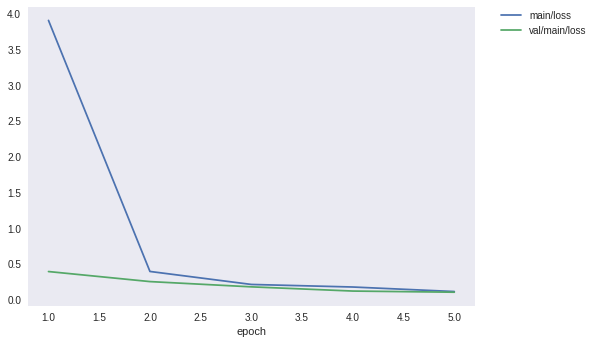

In [21]:
from PIL import Image
Image.open('./result/loss.png')

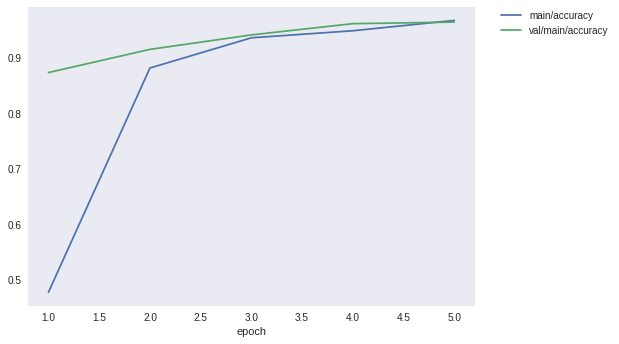

In [22]:
Image.open('./result/accuracy.png')

##学習済みモデルで予測する

###学習済みモデルで、予測するメソッドを定義する

In [0]:
def get_x_test(model, file_path):
  x = Image.open(file_path)
  #型変換
  #float32にする
  x = np.array(x).astype(np.float32) / 255
  #リシェイプ
  x = x.transpose(2, 0, 1)
  # ネットワークと同じデバイス上にデータを送る
  x = model.xp.asarray(x)
  #[ミニバッチ、チャネル、高さ、幅]にする
  x = x[None, ...]
  return x

In [0]:
import matplotlib.pyplot as plt
from chainer.cuda import to_cpu

def get_fruits_name(img_path, model):
  x_test = get_x_test(model,img_path)

  # モデルのforward関数に渡す
  with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
      y = model.predictor(x_test)

  # Variable形式で出てくるので中身を取り出す
  y = y.array

  # 結果をCPUに送る
  y = to_cpu(y)

  # 予測確率の最大値のインデックスを見る
  pred_label = y.argmax(axis=1)[0]

  #結果を返す
  return label_path_list[pred_label]

###適当に30件確認します

In [61]:
from numpy.random import randint

max_index = 30
valid_datasets_len = len(varid_img_path_and_label_list)
for i in range(max_index):
  valid_index = randint(valid_datasets_len)
  img_path, _ = varid_img_path_and_label_list[valid_index]
  pred_label = get_fruits_name(img_path, model)
  print(" predict is {}, image paht is {}".format(pred_label, img_path))

 predict is Passion Fruit, image paht is fruits-360/Validation/Passion Fruit/126_100.jpg
 predict is Mandarine, image paht is fruits-360/Validation/Mandarine/246_100.jpg
 predict is Peach, image paht is fruits-360/Validation/Peach/r_35_100.jpg
 predict is Huckleberry, image paht is fruits-360/Validation/Huckleberry/159_100.jpg
 predict is Clementine, image paht is fruits-360/Validation/Clementine/158_100.jpg
 predict is Quince, image paht is fruits-360/Validation/Quince/300_100.jpg
 predict is Mango, image paht is fruits-360/Validation/Mango/153_100.jpg
 predict is Grapefruit Pink, image paht is fruits-360/Validation/Grapefruit Pink/65_100.jpg
 predict is Carambula, image paht is fruits-360/Validation/Carambula/103_100.jpg
 predict is Carambula, image paht is fruits-360/Validation/Carambula/r_193_100.jpg
 predict is Banana, image paht is fruits-360/Validation/Banana/r_69_100.jpg
 predict is Nectarine, image paht is fruits-360/Validation/Nectarine/r_93_100.jpg
 predict is Banana Red, im